In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
# import candel


%load_ext autoreload
%autoreload 2

In [5]:
from astropy.io import fits
with fits.open("/Users/rstiskalek/Projects/CANDEL/data/test/wise_masked_no_nvss.fits") as fitsfile:
    w1 = fitsfile[1].data['w1'].astype(np.float32)
    w12 = fitsfile[1].data['w12'].astype(np.float32)
    e_w1 = fitsfile[1].data['w1e'].astype(np.float32)
    e_w12 = fitsfile[1].data['w12e'].astype(np.float32)

In [26]:
def double_power_law(x, A, x0, alpha, beta, gamma=1.0):
    """
    Double power-law function.
    """
    xx = x / x0
    return A * xx**(-alpha) * (1.0 + xx**gamma) ** (-(beta - alpha) / gamma)

import numpy as np
from scipy.optimize import curve_fit

# histogram your data
counts, bins = np.histogram(w1, bins="auto")
centers = 0.5 * (bins[1:] + bins[:-1])

# fit double power law
p0 = [1e-6, 1e1, 0.5, 2.0, 1.0]  # initial guess
popt, pcov = curve_fit(double_power_law, centers, counts, p0=p0)

print("Best-fit params:", popt)

Best-fit params: [ 1.07801844e-05  1.01385646e+02  5.49447390e+00 -1.95441826e+01
  1.02639982e+01]


In [64]:
from scipy.interpolate import PchipInterpolator

def bayes_hist_pdf(x, data, edges, alpha=0.5, nsamp=1000):
    edges = np.asarray(edges)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)

    n, _ = np.histogram(data, bins=edges)
    alpha_vec = np.full_like(n, fill_value=alpha, dtype=float)
    alpha_post = alpha_vec + n

    # posterior samples of bin probabilities
    p_samps = np.random.dirichlet(alpha_post, size=nsamp)           # (S, K)
    h_samps = p_samps / widths                                      # heights per unit-x

    # interpolate in log-space to enforce positivity
    pdf_samps = []
    for h in h_samps:
        spl = PchipInterpolator(centers, np.log(h), extrapolate=False)
        y = np.exp(spl(x))
        y[np.isnan(y)] = 0.0
        # renormalize small numerical drift
        Z = np.trapz(y, x)
        pdf_samps.append(y / Z if Z > 0 else y)
    pdf_samps = np.asarray(pdf_samps)                                # (S, len(x))

    pdf_mean = pdf_samps.mean(axis=0)
    lo, hi = np.percentile(pdf_samps, [16, 84], axis=0)
    return pdf_mean, lo, hi, centers, n

# --- usage ---
edges = np.linspace(w1.min(), w1.max(), 31)   # 10 bins
x = np.linspace(edges[0], edges[-1], 800)
pdf, lo, hi, centers, n = bayes_hist_pdf(x, w1, edges, alpha=0.5, nsamp=2000)

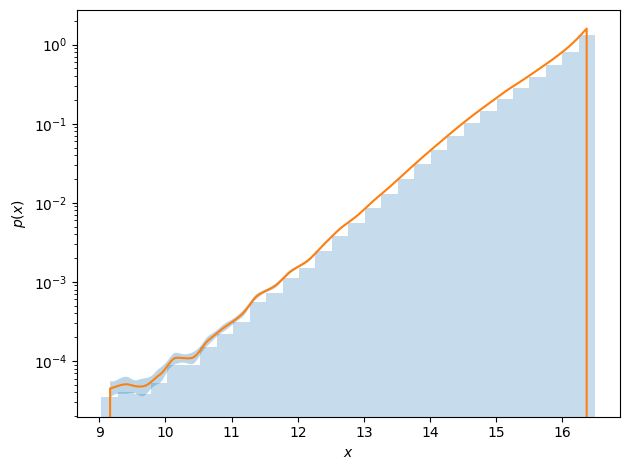

In [63]:

fig, ax = plt.subplots()
ax.hist(w1, bins=edges, density=True, alpha=0.25, label="Histogram")
ax.fill_between(x, lo, hi, alpha=0.3, label="68% band")
ax.plot(x, pdf, label="Bayesian spline PDF")

ax.set_yscale("log")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x)$")
fig.tight_layout()
plt.show()

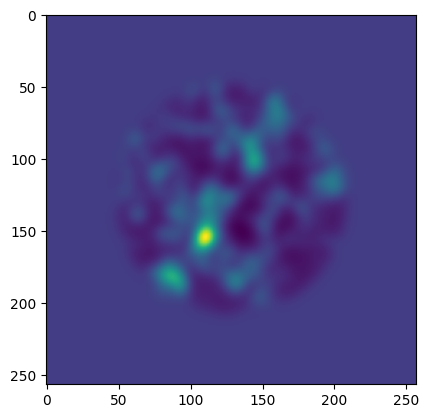

In [27]:
plt.figure()
# plt.imshow(rho[:, :, 128])
plt.imshow(rho_smooth[:, :, 128])

# plt.imshow(rho[:, :, 128] - rho_smooth[:, :, 128])
plt.show()

In [25]:
from h5py import File

with File("/Users/rstiskalek/Projects/CANDEL/data/Foundation/los_Foundation_Carrick2015.hdf5", 'r') as f:
    print(f.keys())
    r = f["r"][...]
    los_density = f["los_density"][...]
    los_velocity = f["los_velocity"][...]

# los_delta = los_density / (0.3111 * 275.4) - 1



<KeysViewHDF5 ['RA', 'dec', 'los_density', 'los_velocity', 'r']>


In [6]:
alpha = 0.65
eps = 1.5
rho_exp = 0.4

b = (1 + los_delta)**alpha * np.exp(-((1 + los_delta) / rho_exp)**(-eps))
b2 = (1 + los_delta)**alpha
# b = np.exp(-((1 + los_delta) / rho_exp)**(-eps))

IndexError: index 1 is out of bounds for axis 0 with size 1

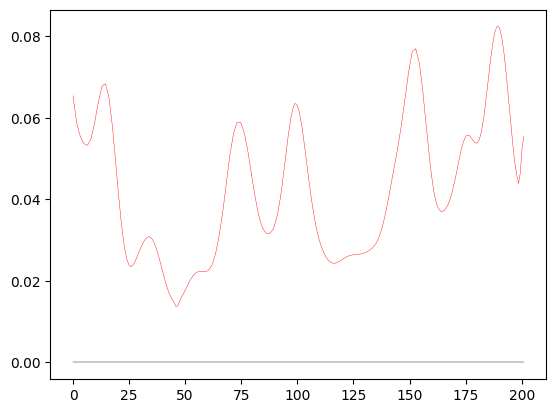

In [7]:
plt.figure()
for i in range(30):
    # plt.plot(r, los_density[i, 50, :] / (0.3111 * 275.4), c="k", lw=0.3)
    plt.plot(r, b[i, 50, :], c="k", lw=0.3)
    plt.plot(r, b2[i, 50, :], c="red", lw=0.3)


plt.xlabel(r"$r ~ [h^{-1}\,\mathrm{Mpc}]$")
plt.ylabel(r"$\rho / \bar{\rho}$")

plt.ylim(1e-1, 10)
# plt.yscale("log")

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/los_density_profiles.png", dpi=450)

plt.show()

In [5]:
z2r = candel.Redshift2Distance(is_scalar=True)

In [7]:
z2r(0.25)

Array(705.6982, dtype=float32)

In [25]:
import candel

# config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
config_path = "/Users/rstiskalek/Projects/CANDEL/results_test/precomputed_los_precomputed_los_Carrick2015_Clusters_noMNR_LT.toml"
data = candel.pvdata.load_PV_dataframes(config_path,)
data

2025-08-27 20:56:57 loading 1 PV dataframes: ['Clusters']
2025-08-27 20:56:57 loading existing LOS data from /Users/rstiskalek/Projects/CANDEL/data/Clusters/los_Clusters_Carrick2015.hdf5.
2025-08-27 20:56:57 initially loaded 312 clusters.
2025-08-27 20:56:57 removed 62 clusters, thus 250 remain.
2025-08-27 20:56:57 subtracting the mean logT from the data.
2025-08-27 20:56:57 subtracting the mean logY from the data.
2025-08-27 20:56:57 setting the LOS radial grid from 0.1 to 1001 with 501 points.
2025-08-27 20:56:57 marginalising over 1 field realisations.


<PVDataFrame: 250 galaxies>

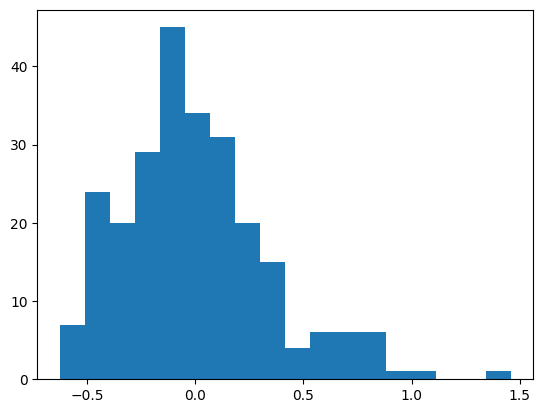

In [26]:
plt.figure()
plt.hist(data["logY"], bins="auto")
# plt.axvline(0.12, c="red")
plt.show()

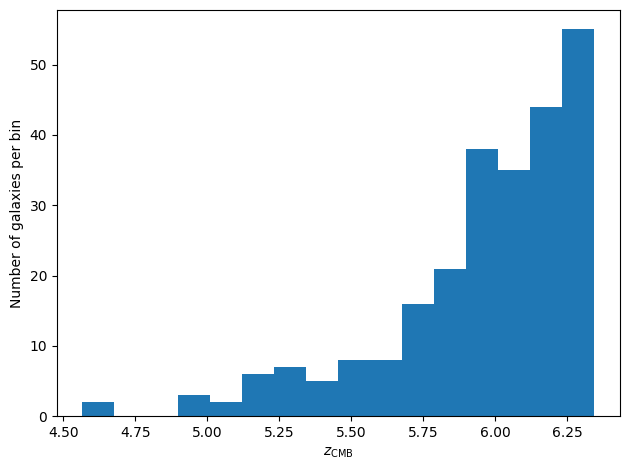

In [27]:
plt.figure()
plt.hist(-data["logF"], bins="auto")
plt.xlabel(r"$z_{\rm CMB}$")
plt.ylabel("Number of galaxies per bin")
plt.tight_layout()
# plt.savefig("/Users/rstiskalek/Downloads/zcmb_histogram.png", dpi=450)
plt.show()

In [52]:
from h5py import File

with File("/Users/rstiskalek/Projects/CANDEL/results_test/Vext_Clusters_noMNR_LTY.hdf5", 'r') as f:
    grp = f["samples"]
    print(grp.keys())
    R = grp["R_dist_emp"][...]
    n = grp["n_dist_emp"][...]
    p = grp["p_dist_emp"][...]

    
    a = grp["A_CL"][...]
    c = grp["C_CL"][...]
    # beta = grp["beta"][...]


<KeysViewHDF5 ['A_CL', 'B_CL', 'C_CL', 'R_dist_emp', 'Vext', 'Vext_b', 'Vext_ell', 'Vext_mag', 'n_dist_emp', 'p_dist_emp', 'sigma_int', 'sigma_v']>


In [53]:
np.polyfit(a, c, deg=1)

array([-0.21669556, -0.02694531])

In [ ]:
c = -0.03085456 -0.218304 * x

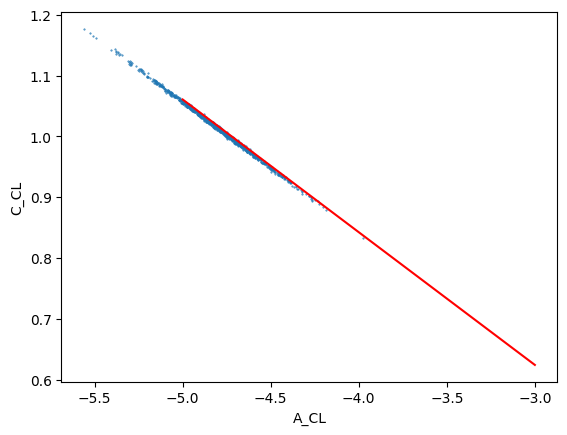

In [54]:
plt.figure()
plt.scatter(a, c, s=0.2)

x = np.linspace(-5, -3, 100)
plt.plot(x, -0.03085456 -0.218304 * x, c='red')

plt.xlabel("A_CL")
plt.ylabel("C_CL")
plt.show()

In [29]:

y = np.full((len(R), len(data["r_grid"])), np.nan)
for k in range(len(R)):
    y[k] = candel.model.log_prior_r_empirical(data["r_grid"], R[k], p[k], n[k], data["r_grid"][-1])

y = np.exp(y)

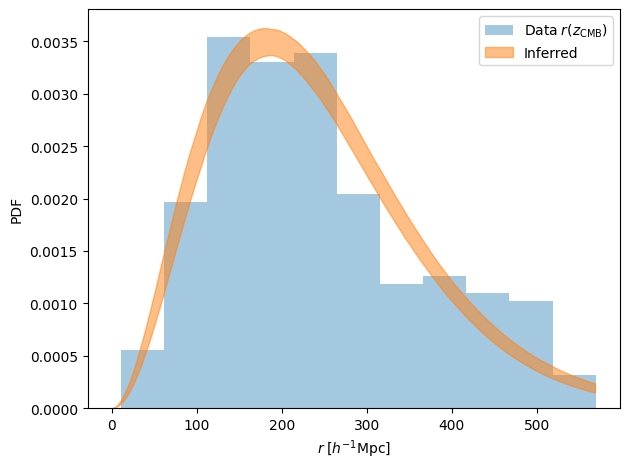

In [30]:
z2r = candel.Redshift2Distance()


r_data = z2r(data["zcmb"], h=1)
plt.figure()
plt.hist(r_data, bins="auto", density=True, alpha=0.4,
         label=r"$\mathrm{Data}\;r(z_{\rm CMB})$", color="C0")

mask = data["r_grid"] < r_data.max()
plt.fill_between(
    data["r_grid"][mask],
    np.nanpercentile(y, 16, axis=0)[mask],
    np.nanpercentile(y, 84, axis=0)[mask],
    color="C1", alpha=0.5, label="Inferred"
)

plt.legend()
plt.ylabel("PDF")
plt.xlabel(r"$r\;[h^{-1}\mathrm{Mpc}]$")
# plt.xlabel(r"$r\;[\mathrm{Mpc}]$")

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/test_cluster.png", dpi=450)

plt.show()

In [16]:
from jax import numpy as jnp
from jax.scipy.special import gammaln, gammainc

def log_prior_r_empirical(r, R, p, n, Rmax_grid, Rmax_truncate=None):
    """
    Log of the (empirical) truncated prior:
        π(r) ∝ r^p * exp(-(r/R)^n),   0 < r ≤ Rmax
    Normalized by Z = [R^(1+p) * γ(a, x)] / n with a = (1+p)/n, x = (Rmax/R)^n
    """
    if Rmax_truncate is None:
        Rmax = Rmax_grid
    else:
        Rmax = jnp.minimum(Rmax_grid, Rmax_truncate)

    a = (1.0 + p) / n
    x = (Rmax / R) ** n

    # log γ(a, x) = log Γ(a) + log P(a, x), P = regularized lower γ
    log_gamma_lower = (
        gammaln(a) + jnp.log(jnp.clip(gammainc(a, x), 1e-300, 1.0)))
    log_norm = (1.0 + p) * jnp.log(R) - jnp.log(n) + log_gamma_lower

    logpdf = p * jnp.log(r) - (r / R)**n - log_norm
    valid = (r > 0) & (r <= Rmax)
    return jnp.where(valid, logpdf, -jnp.inf)

In [39]:
r = jnp.linspace(0., 200, 10000)

R = 100
p = 2
n = 2
Rmax_grid = r.max()

Rmax_truncate = 175


y = jnp.exp(log_prior_r_empirical(r, R, p, n, Rmax_grid, Rmax_truncate=Rmax_truncate))

In [40]:
from scipy.integrate import simpson


simpson(y, x=r)

1.0000376591964684

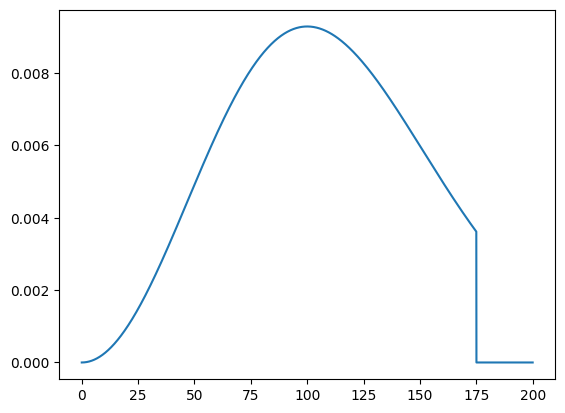

: 

In [ ]:
plt.figure()
plt.plot(r, y)

plt.show()

In [88]:
from h5py import File

with File("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/los_SH0ES_TFR_Carrick2015.hdf5") as f:
    r = f["r"][...]
    los_velocity = f["los_density"][...]

In [99]:
ngal = 37

f = candel.model.LOSInterpolator(r, los_velocity, r0_decay_many_steps=10)


# rtest = np.random.uniform(20, 30, ngal)

z = f(rtest)

In [100]:
r_eval = np.linspace(0, 150, 100)


Z = f.interp_many_steps_per_galaxy(r_eval)

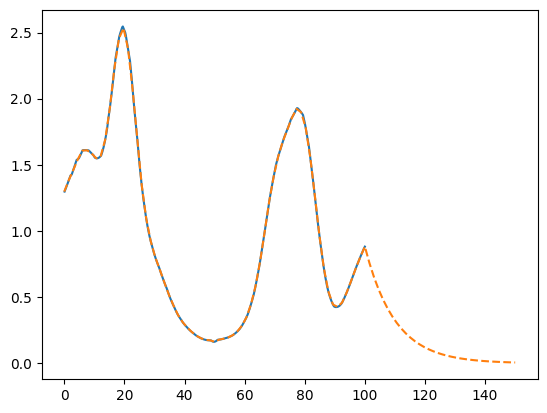

In [101]:
k = 30

plt.figure()

plt.plot(r, los_velocity[0, k, :])

plt.plot(r_eval, Z[0, k, :], ls="--")


plt.show()

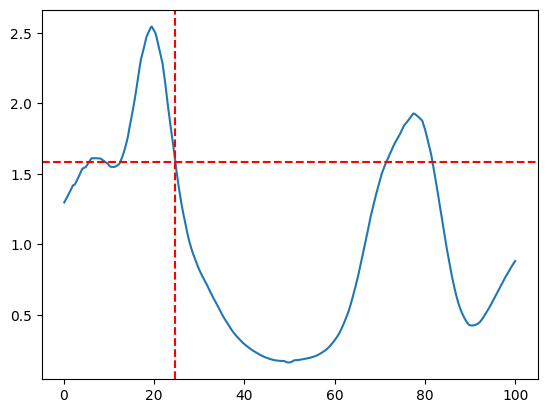

In [66]:
k = 30

plt.figure()
plt.plot(r, los_velocity[0, k, :])

plt.axvline(rtest[k], color="red", ls="--")
plt.axhline(z[0, k], color="red", ls="--")



plt.show()


In [46]:
z[0] - z[1]

Array([-0.39035034, -2.425476  , -0.55255127, -0.33633423, -0.42901993,
       -1.5334167 , -0.90448   , -0.28881836, -5.060974  ,  1.9458923 ,
       -3.3988647 , -2.1777344 ,  2.3356323 ,  1.4673462 ,  2.4840698 ,
        1.3243408 ,  0.09307861, -0.9248657 ,  0.6022949 ,  4.269226  ,
       -2.881897  ,  1.8832932 , -0.55570793,  1.3221741 ,  0.03939819,
       -1.2784805 ,  2.1064758 ,  0.24169922,  2.1488495 ,  3.5736694 ,
        1.3278198 , -2.2939148 , -1.1083908 ,  0.12689209,  0.11914062,
       -2.5375977 ,  0.5322876 ], dtype=float32)

In [38]:
z[0] - z[1]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification ((0, 1), 0) for value tree PyTreeDef((*, *)).

In [57]:
d = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
q_names = d["q_names"][:37]

q_names = [str(x) for x in q_names]
q_names = [x.replace("mu_", "") for x in q_names]


2025-06-24 16:20:38 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-24 16:20:38 indices of zero width: [44]
2025-06-24 16:20:38 found zero-width prior at index 44. Setting it to 0.


In [116]:
from h5py import File

fname = "/Users/rstiskalek/Projects/CANDEL/results/CH0/Cepheid_distances_r2_prior.hdf5"
with File(fname, "r") as f:
    mu_host = f["samples/mu_host"][...]


In [117]:
f = np.load("/Users/rstiskalek/Downloads/ceph_distance_and_cov_Kenworthy.npz")

names_test = f["arr_0"]
names_test = [str(x).upper() for x in names_test]
mu_host_test = f["arr_1"]
mu_host_test_cov = f["arr_2"]


names_test[names_test.index("N976A")] = "N0976"
names_test[names_test.index("N105A")] = "N0105"

index_map = {name: i for i, name in enumerate(q_names)}
ks = np.argsort([index_map[name] for name in names_test])

names_test = [names_test[i] for i in ks]
mu_host_test = mu_host_test[ks]

mu_host_test_cov = mu_host_test_cov[ks][:, ks]

In [119]:
np.diag(mu_host_test_cov)**0.5

array([0.04136864, 0.12265181, 0.10875452, 0.07381132, 0.24984403,
       0.05939251, 0.05582396, 0.03665536, 0.06135057, 0.06428326,
       0.09907942, 0.15365332, 0.15834673, 0.16536373, 0.0761289 ,
       0.05125609, 0.03445687, 0.07974353, 0.08890576, 0.07143673,
       0.11614233, 0.12826766, 0.05027795, 0.0836281 , 0.20465913,
       0.07414205, 0.0518968 , 0.05217549, 0.20506994, 0.09938517,
       0.12017914, 0.12465113, 0.11706553, 0.11874364, 0.15341313,
       0.1490802 , 0.06669936], dtype=float32)

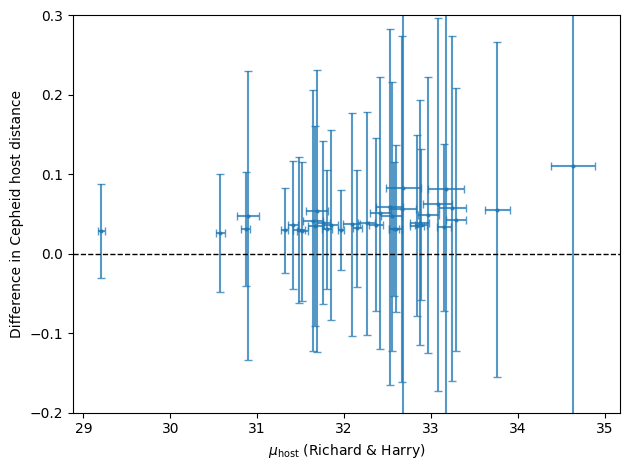

In [128]:
mu_host_mean = np.mean(mu_host, axis=0)

xerr = np.std(mu_host, axis=0)


yerr = np.sqrt(xerr**2 + np.diag(mu_host_test_cov))

plt.figure()

plt.errorbar(mu_host_mean, mu_host_mean - mu_host_test,
             xerr=xerr, yerr=yerr, fmt="o", markersize=2, capsize=3, alpha=0.75)
plt.axhline(0, color="k", ls="--", lw=1)

plt.ylim(-0.2, 0.3)


plt.xlabel(r"$\mu_{\rm host}$ (Richard & Harry)")
plt.ylabel(r"Difference in Cepheid host distance")


plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/ceph_host_distance_comparison.png", dpi=300)



plt.show()

In [129]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='LR')

# Priors
priors = ['H0', 'M_W', 'b_W', 'Z_W', 'σ_v', 'β', 'μ_host', 'μ_N4258', 'μ_LMC', 'μ_M31', 'dZP']
for p in priors:
    dot.node(p, shape='ellipse')

# Deterministic nodes
dot.node('Vpec', 'Vpec = f(μ_host)\n(interp. from C15)', shape='box')
dot.node('cz_pred', 'cz_pred = predict_cz(μ_host, Vpec)', shape='box')
dot.node('μ_cepheid', 'μ_cepheid = L_host_dist @ [μ_host, μ_N4258 + dZP, μ_LMC, μ_M31]', shape='box')
dot.node('mag_pred', 'mag_pred = μ_cepheid + M_W + b_W·logP + Z_W·OH', shape='box')

# Likelihood nodes
dot.node('μ_N4258_ll', 'μ_N4258_ll', shape='diamond', style='filled', fillcolor='lightgray')
dot.node('μ_LMC_ll', 'μ_LMC_ll', shape='diamond', style='filled', fillcolor='lightgray')
dot.node('redshift_ll', 'Redshift Likelihood', shape='diamond', style='filled', fillcolor='lightgray')
dot.node('cepheid_ll', 'Cepheid magnitude\nLikelihood', shape='diamond', style='filled', fillcolor='lightgray')

# Edges
dot.edge('μ_host', 'Vpec')
dot.edge('Vpec', 'cz_pred')
dot.edge('H0', 'cz_pred')
dot.edge('cz_pred', 'redshift_ll')

dot.edge('μ_host', 'μ_N4258_ll')
dot.edge('μ_N4258', 'μ_N4258_ll')
dot.edge('μ_host', 'μ_LMC_ll')
dot.edge('μ_LMC', 'μ_LMC_ll')

dot.edge('μ_host', 'μ_cepheid')
dot.edge('μ_N4258', 'μ_cepheid')
dot.edge('μ_LMC', 'μ_cepheid')
dot.edge('μ_M31', 'μ_cepheid')
dot.edge('dZP', 'μ_cepheid')

dot.edge('μ_cepheid', 'mag_pred')
dot.edge('M_W', 'mag_pred')
dot.edge('b_W', 'mag_pred')
dot.edge('Z_W', 'mag_pred')

dot.edge('mag_pred', 'cepheid_ll')

# Render
dot.render('sh0es_model_diagram', view=True)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
!python 

In [109]:
np.mean(mu_host_mean - mu_host_test)

0.04413981

In [92]:
for i in range(37):
    print(q_names[i], names_test[i])

M101 M101
M1337 M1337
N0691 N0691
N1015 N1015
N0105 N0105
N1309 N1309
N1365 N1365
N1448 N1448
N1559 N1559
N2442 N2442
N2525 N2525
N2608 N2608
N3021 N3021
N3147 N3147
N3254 N3254
N3370 N3370
N3447 N3447
N3583 N3583
N3972 N3972
N3982 N3982
N4038 N4038
N4424 N4424
N4536 N4536
N4639 N4639
N4680 N4680
N5468 N5468
N5584 N5584
N5643 N5643
N5728 N5728
N5861 N5861
N5917 N5917
N7250 N7250
N7329 N7329
N7541 N7541
N7678 N7678
N0976 N0976
U9391 U9391


In [82]:
ks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

In [80]:
names_test, q_names

(['M101',
  'M1337',
  'N0691',
  'N1015',
  'N0105',
  'N1309',
  'N1365',
  'N1448',
  'N1559',
  'N2442',
  'N2525',
  'N2608',
  'N3021',
  'N3147',
  'N3254',
  'N3370',
  'N3447',
  'N3583',
  'N3972',
  'N3982',
  'N4038',
  'N4424',
  'N4536',
  'N4639',
  'N4680',
  'N5468',
  'N5584',
  'N5643',
  'N5728',
  'N5861',
  'N5917',
  'N7250',
  'N7329',
  'N7541',
  'N7678',
  'N0976',
  'U9391'],
 ['M101',
  'M1337',
  'N0691',
  'N1015',
  'N0105',
  'N1309',
  'N1365',
  'N1448',
  'N1559',
  'N2442',
  'N2525',
  'N2608',
  'N3021',
  'N3147',
  'N3254',
  'N3370',
  'N3447',
  'N3583',
  'N3972',
  'N3982',
  'N4038',
  'N4424',
  'N4536',
  'N4639',
  'N4680',
  'N5468',
  'N5584',
  'N5643',
  'N5728',
  'N5861',
  'N5917',
  'N7250',
  'N7329',
  'N7541',
  'N7678',
  'N0976',
  'U9391'])

In [65]:
names_test

['M101',
 'M1337',
 'N0691',
 'N1015',
 'N105A',
 'N1309',
 'N1365',
 'N1448',
 'N1559',
 'N2442',
 'N2525',
 'N2608',
 'N3021',
 'N3147',
 'N3254',
 'N3370',
 'N3447',
 'N3583',
 'N3972',
 'N3982',
 'N4038',
 'N4424',
 'N4536',
 'N4639',
 'N4680',
 'N5468',
 'N5584',
 'N5643',
 'N5728',
 'N5861',
 'N5917',
 'N7250',
 'N7329',
 'N7541',
 'N7678',
 'N976A',
 'U9391']

In [56]:
q_names

['mu_M101',
 'mu_M1337',
 'mu_N0691',
 'mu_N1015',
 'mu_N0105',
 'mu_N1309',
 'mu_N1365',
 'mu_N1448',
 'mu_N1559',
 'mu_N2442',
 'mu_N2525',
 'mu_N2608',
 'mu_N3021',
 'mu_N3147',
 'mu_N3254',
 'mu_N3370',
 'mu_N3447',
 'mu_N3583',
 'mu_N3972',
 'mu_N3982',
 'mu_N4038',
 'mu_N4424',
 'mu_N4536',
 'mu_N4639',
 'mu_N4680',
 'mu_N5468',
 'mu_N5584',
 'mu_N5643',
 'mu_N5728',
 'mu_N5861',
 'mu_N5917',
 'mu_N7250',
 'mu_N7329',
 'mu_N7541',
 'mu_N7678',
 'mu_N0976',
 'mu_U9391']

In [51]:
q_names

array(['mu_M101', 'mu_M1337', 'mu_N0691', 'mu_N1015', 'mu_N0105',
       'mu_N1309', 'mu_N1365', 'mu_N1448', 'mu_N1559', 'mu_N2442',
       'mu_N2525', 'mu_N2608', 'mu_N3021', 'mu_N3147', 'mu_N3254',
       'mu_N3370', 'mu_N3447', 'mu_N3583', 'mu_N3972', 'mu_N3982',
       'mu_N4038', 'mu_N4424', 'mu_N4536', 'mu_N4639', 'mu_N4680',
       'mu_N5468', 'mu_N5584', 'mu_N5643', 'mu_N5728', 'mu_N5861',
       'mu_N5917', 'mu_N7250', 'mu_N7329', 'mu_N7541', 'mu_N7678',
       'mu_N0976', 'mu_U9391'], dtype='<U14')

In [39]:
f

NpzFile '/Users/rstiskalek/Downloads/ceph_distance_and_cov_Kenworthy.npz' with keys: arr_0, arr_1, arr_2

In [42]:
mu_host_test

array([29.178076, 32.91962 , 32.83039 , 32.56303 , 34.526833, 32.541256,
       31.377995, 31.286837, 31.491325, 31.449879, 32.051437, 32.61246 ,
       32.463623, 33.01421 , 32.33096 , 32.120182, 31.935629, 32.803528,
       31.634571, 31.722374, 31.603462, 30.844364, 30.834663, 31.812387,
       32.599144, 33.116386, 31.771675, 30.546497, 33.093914, 32.223003,
       32.36317 , 31.627949, 33.246086, 32.50041 , 33.18692 , 33.709213,
       32.84797 ], dtype='>f4')

In [10]:
np.savez("mu_host.npz", mu_host=mu_host, q_names=q_names)

In [11]:
f = np.load("mu_host.npz", allow_pickle=True)

mu_host = f["mu_host"]
q_names = f["q_names"]

In [24]:
C = np.cov(mu_host.T)

stddev = np.sqrt(np.diag(C))
corr = C / np.outer(stddev, stddev)


corr[np.isclose(corr, 1)] = np.nan

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_13727/3139744569.py:10: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(C))


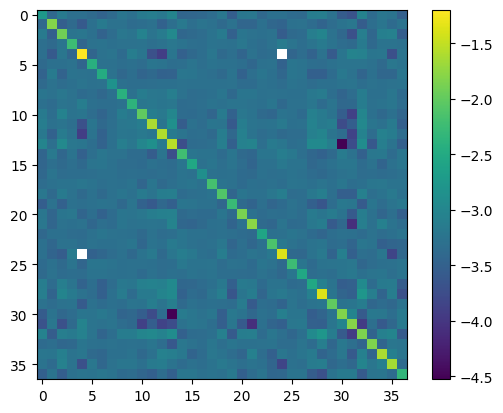

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

vmax = np.max(np.abs(C))
linthresh = 1e-4  # threshold below which scaling is linear

plt.figure()
# im = plt.imshow(C, cmap="viridis", norm=SymLogNorm(linthresh=linthresh, vmin=-vmax, vmax=vmax))
# plt.colorbar(im)
plt.imshow(np.log10(C))
plt.colorbar()
plt.show()

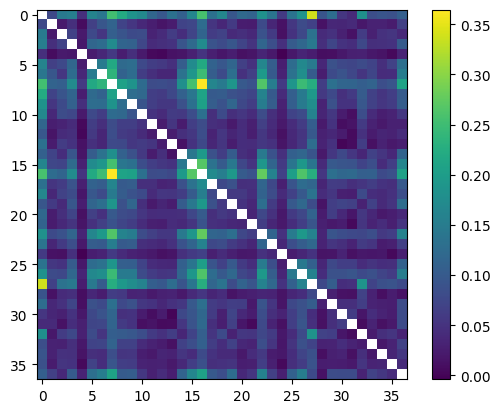

In [29]:
plt.figure()
plt.imshow(corr, cmap="viridis", )
plt.colorbar()
plt.show()

(36000, 37)

In [33]:
k = 30

r1 = 50
r2 = 50

candel.cosmo.compute_Fuv(k * r1, k * r2, 1, ell_max=2000)

0.33333333333333376

In [7]:
npoints = 10

RA = np.random.uniform(0, 360, npoints)
dec = np.random.uniform(-60, 60, npoints)
r = np.random.uniform(0, 100, npoints)

k, Pk = candel.cosmo.get_Pk_CAMB()
k_old, Pk_old = np.load("/Users/rstiskalek/Projects/PecVelCov.jl/data/pk_fiducial.npy").T
dDdtau = candel.cosmo.compute_dD_dtau()

C2 = candel.cosmo.compute_covariance_matrix(r, RA, dec, k, Pk, dDdtau, n_jobs=10, ell_max=2000)

100%|██████████| 55/55 [00:03<00:00, 14.18it/s]


In [19]:
from scipy.integrate import simpson

print(f"dDdtau = {dDdtau}")

xi_ii = dDdtau**2 * simpson(Pk, x=k) / (2 * np.pi**2) / 3
print(f"xi_ii^0.5 = {xi_ii**0.5}")

dDdtau = 35.55608580131215
xi_ii^0.5 = 251.9349724679233


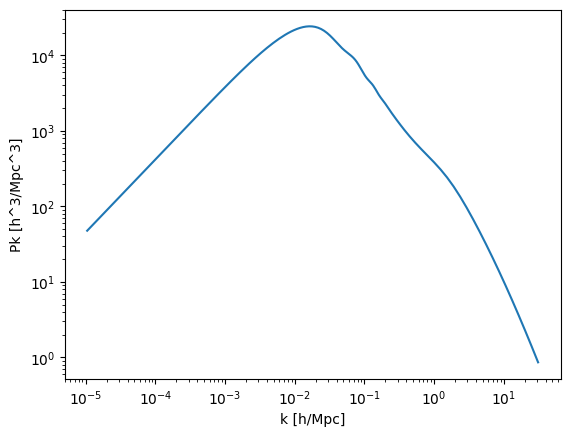

In [20]:
plt.figure()
plt.plot(k, Pk, label="Pk")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("k [h/Mpc]")
plt.ylabel("Pk [h^3/Mpc^3]")
plt.show()

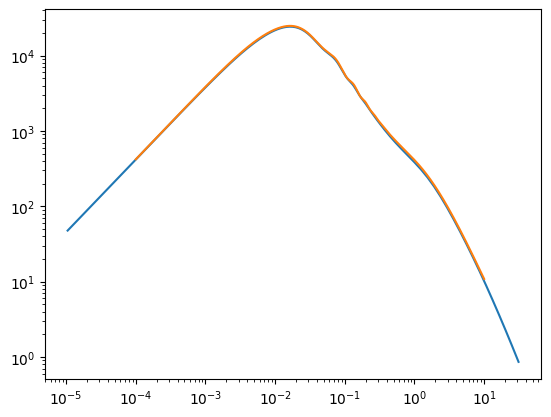

In [63]:
plt.figure()
plt.plot(k, Pk, label="CAMB")
plt.plot(k_old, Pk_old, label="PecVelCov.jl")
plt.xscale("log")
plt.yscale("log")

plt.show()


In [57]:
np.diag(C2)**0.5

array([208.18420201, 208.07742177, 208.28298456, 208.07599969,
       207.98800404, 208.30192813, 208.20385613, 207.93297885,
       208.2965132 , 208.15183707])

In [58]:
np.diag(C2)**0.5

array([208.18420201, 208.07742177, 208.28298456, 208.07599969,
       207.98800404, 208.30192813, 208.20385613, 207.93297885,
       208.2965132 , 208.15183707])

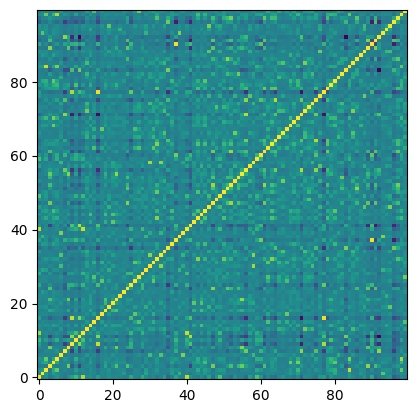

In [5]:
plt.figure()
plt.imshow(C, cmap='viridis', origin='lower')

plt.show()

array(0.77564834)

In [26]:
f_cached(x, y, costheta)

0.060730805356773755

In [14]:



x = 2
y = 3
costheta = 1
tot = 0
for ell in range(0, 100):
    P_l = eval_legendre(ell, costheta)
    jl_x = spherical_jn(ell, x, derivative=True)
    jl_y = spherical_jn(ell, y, derivative=True)
    tot += (2 * ell + 1) * jl_x * jl_y * P_l

tot

0.23913362692838297

In [47]:
import numpy as np
import camb
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy import integrate
from astropy.cosmology import Planck18 as cosmo

# -----------------------------------------------------------------
# STEP 1: Get P(k) from CAMB

def get_Pk_CAMB(H0=67.36, Om0=0.3153, As=2.100549e-9, ns=0.9649, kmax=10.0):
    pars = camb.CAMBparams()
    h = H0 / 100.0
    ombh2 = 0.02237
    omch2 = Om0 * h**2 - ombh2

    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_matter_power(redshifts=[0], kmax=kmax)

    results = camb.get_results(pars)
    k, z_out, Pk = results.get_linear_matter_power_spectrum(hubble_units=False, k_hunit=True)
    return k, Pk[0]

def build_Pk_interpolator():
    k, Pk = get_Pk_CAMB()
    logk = np.log(k)
    logPk = np.log(Pk)
    interp = interp1d(logk, logPk, kind="cubic", bounds_error=False, fill_value="extrapolate")
    return lambda k_eval: np.exp(interp(np.log(k_eval)))

# -----------------------------------------------------------------
# STEP 2: Implement F(u, v, cosθ) via Legendre sum

def F_uv_legendre(u, v, costheta, ell_max=30):
    F = 0.0
    for ell in range(ell_max + 1):
        prefactor = (2*ell + 1)
        jl_u = spherical_jn(ell, u)
        jl_v = spherical_jn(ell, v)
        P_l = legendre(ell)(costheta)
        F += prefactor * jl_u * jl_v * P_l
    return F

# -----------------------------------------------------------------
# STEP 3: Compute dD/dτ (conformal time derivative of linear growth)

def dD_dtau(z):
    a = 1 / (1 + z)
    H = cosmo.H(z).value  # H(z) in km/s/Mpc
    f = cosmo.Om(z)**0.55
    D = a  # since we're assuming LCDM normalization D(a)=a at low z
    return a * H * f * D

# -----------------------------------------------------------------
# STEP 4: Compute velocity covariance for one pair

def velocity_covariance(chi_i, chi_j, costheta, Pk_interp):
    dD_dt_i = dD_dtau(0)  # assuming z=0 for now
    dD_dt_j = dD_dtau(0)

    def integrand(k):
        u, v = k * chi_i, k * chi_j
        Fval = F_uv_legendre(u, v, costheta)
        return (Pk_interp(k) * Fval * k**2) / (2 * np.pi**2)

    result = integrate.quad(integrand, 1e-4, 10, epsabs=1e-4, epsrel=1e-4, limit=300)[0]
    return dD_dt_i * dD_dt_j * result

# -----------------------------------------------------------------
# STEP 5: Compute full covariance matrix

def compute_covariance_matrix(positions_xyz):
    N = len(positions_xyz)
    Sigma = np.zeros((N, N))
    Pk_interp = build_Pk_interpolator()

    chis = np.linalg.norm(positions_xyz, axis=1)
    rhat = positions_xyz / chis[:, None]

    for i in range(N):
        for j in range(i, N):
            costheta = np.dot(rhat[i], rhat[j])
            cov = velocity_covariance(chis[i], chis[j], costheta, Pk_interp)
            Sigma[i, j] = cov
            Sigma[j, i] = cov
    return Sigma

# -----------------------------------------------------------------
# STEP 6: Example usage

if __name__ == "__main__":
    positions_mpc = np.array([
        [0, 0, 0],
        [20, 0, 0],
        [0, 30, 0],
        [0, 0, 50],
    ])

    Sigma = compute_covariance_matrix(positions_mpc)
    print(Sigma)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_41494/99562481.py:79: RuntimeWarning: invalid value encountered in divide
  rhat = positions_xyz / chis[:, None]
/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_41494/99562481.py:67: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(integrand, 1e-4, 10, epsabs=1e-4, epsrel=1e-4, limit=300)[0]


[[           nan            nan            nan            nan]
 [           nan 2.94024610e+04 8.86202017e+01 2.47422043e+01]
 [           nan 8.86202017e+01 2.12242441e+04 1.83972421e+01]
 [           nan 2.47422043e+01 1.83972421e+01 1.33945074e+04]]


In [49]:
(2.94024610e+04)**0.5

171.47145826638322

In [53]:
from scipy.special import spherical_jn, legendre

def F_uv_legendre(u, v, costheta, ell_max=30):
    F = 0.0
    for ell in range(ell_max + 1):
        prefactor = (2*ell + 1)
        jl_u = spherical_jn(ell, u)
        jl_v = spherical_jn(ell, v)
        P_l = legendre(ell)(costheta)
        F += prefactor * jl_u * jl_v * P_l
    return F

In [57]:
F_uv_legendre(0.001, 0.001, 30)

1.0000096666947

In [26]:
k, z_out, Pk = get_Pk_CAMB()

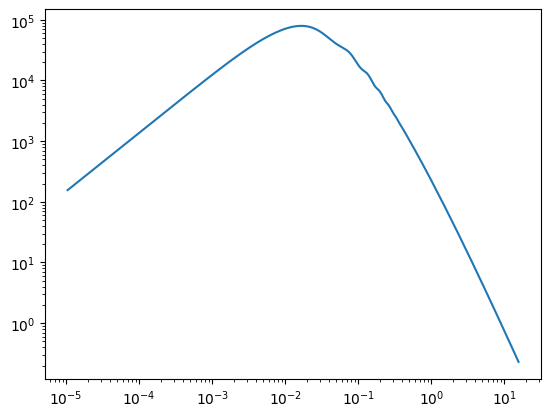

In [27]:
plt.figure()
plt.plot(k, Pk, label='z=0')
plt.yscale("log")
plt.xscale("log")
plt.show()

In [11]:
res[3]

IndexError: tuple index out of range

In [2]:
import numpy as np
from scipy import integrate
from scipy.special import spherical_jn
from astropy.cosmology import Planck15 as cosmo

# PARAMETERS
H0 = cosmo.H0.value  # km/s/Mpc
Om0 = cosmo.Om0
c = 299792.458  # km/s

# Growth rate f ~ Om0^gamma
def growth_rate(Om0, gamma=0.55):
    return Om0**gamma

f = growth_rate(Om0)

# Load or compute linear matter power spectrum
# For demonstration, use a toy P_m(k): P(k) = k^n * exp(-k/k_cut)
def P_m(k):
    k_cut = 0.2  # 1/Mpc
    n_s = 0.96
    A_s = 1e4  # amplitude in (Mpc/h)^3
    return A_s * k**n_s * np.exp(-k/k_cut)

# Velocity power spectrum P_v(k)
def P_v(k):
    return (H0 * f / k)**2 * P_m(k)

# Compute Sigma(r) for a given separation
def sigma_r(r):
    integrand = lambda k: (P_v(k) * spherical_jn(0, k * r) * k**2) / (2 * np.pi**2)
    result = integrate.quad(integrand, 1e-4, 10, limit=500, epsabs=0, epsrel=1e-4)[0]
    return result

# Example: compute covariance matrix for N galaxies
def compute_velocity_covariance(positions_mpc):
    N = len(positions_mpc)
    Sigma = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            rij = np.linalg.norm(positions_mpc[i] - positions_mpc[j])
            cov = sigma_r(rij)
            Sigma[i, j] = cov
            Sigma[j, i] = cov
    return Sigma

# EXAMPLE POSITIONS
# positions in Mpc, shape (N, 3) in Cartesian coords
positions_mpc = np.array([
    [0, 0, 0],
    [20, 0, 0],
    [0, 30, 0],
    [0, 0, 50],
])

Sigma = compute_velocity_covariance(positions_mpc)
print(Sigma)

[[26661.86062664  1703.5905666    797.99267738   299.2697091 ]
 [ 1703.5905666  26661.86062664   561.87699492   259.19887157]
 [  797.99267738   561.87699492 26661.86062664   222.14248386]
 [  299.2697091    259.19887157   222.14248386 26661.86062664]]


In [3]:
26661.86062664**0.5

163.28460009027182

In [43]:
f = np.load("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PP_SN_matched_to_SH0ES.npz")  # noqa
pp = f["pp_matched"]
C_SN_from_pp = f["cov"]
m_calibrator = pp["IS_CALIBRATOR"] == 1
m_HF = pp["USED_IN_SH0ES_HF"] == 1

# print(pp[m_calibrator]["m_b_corr"] - Y_SN_Cepheid)
C_SN = C_SN_from_pp
Y_SN = pp["m_b_corr"]

In [44]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path, )

2025-06-16 22:20:56 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-16 22:20:56 indices of zero width: [44]
2025-06-16 22:20:56 found zero-width prior at index 44. Setting it to 0.
Replacing2!


In [32]:
H0_fiducial = 73
Y = (pp["m_b_corr"] - 5 * np.log10(candel.redshift_to_dL_cosmography(pp["zHD"], H0_fiducial) * H0_fiducial) - 25)#[m_HF]
Y[m_calibrator] = pp["m_b_corr"][m_calibrator]


In [33]:
f = np.load("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PP_SN_matched_to_SH0ES.npz")  # noqa
pp = f["pp_matched"]

In [34]:
Y.shape

(354,)

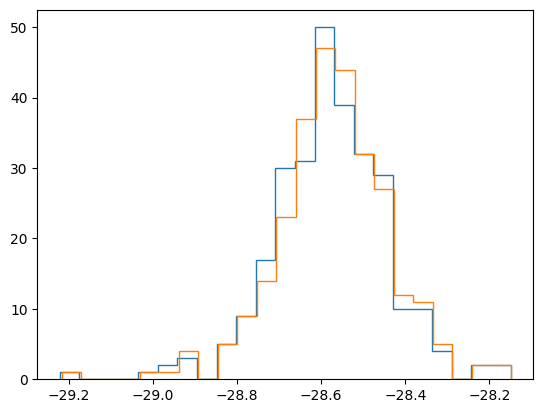

In [35]:
plt.figure()
# plt.scatter(Y[77:], data["Y_SN"][77:])

plt.hist(Y[77:], bins="auto", histtype="step", )
plt.hist(data["Y_SN"][77:], bins="auto", histtype="step")



plt.show()

In [ ]:
Om = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=Om, Tcmb0=2.725)


z = np.linspace(0, 0.1, 100)

dL = cosmo.luminosity_distance(z).value

dL_test = redshift_to_dL_cosmography(
    z, 
    H0=cosmo.H0.value, 
    q0=-0.55, 
    j0=1)

In [ ]:
plt.figure()
plt.plot(z, dL - dL_test, label='Astropy')
# plt.plot(z, dL_test , label='Cosmography')

plt.show()

In [ ]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
data = candel.pvdata.load_PV_dataframes(config_path,)
data

In [ ]:
(data["mag"] > 5).sum()

In [ ]:
3246 - 3290

In [ ]:
4528 - 3246

In [ ]:
44 removed due to the galactic latitude

In [ ]:
d1 = data[0]
d2 = data[1]


In [ ]:
np.isin(d1["pgc"], d2["pgc"]).sum(), np.isin(d2["pgc"], d1["pgc"]).sum()

In [ ]:
model1 = candel.model.TFRModel_DistMarg(config_path) 
model2 = candel.model.TFRModel_DistMarg(config_path)

model = candel.model.JointPVModel([model1, model2], ["beta"])

In [ ]:
model_kwargs = {"data": data, }

In [ ]:
samples, log_density = candel.run_pv_inference(model, model_kwargs,)

In [ ]:
# model = candel.model.PantheonPlusModel_DistMarg(config_path)
# model = candel.model.TFRModel_DistMarg(config_path)
model = candel.model.Clusters_DistMarg(config_path,)

# model = candel.model.FPModel_DistMarg(config_path)

model_kwargs = {"data": data,}
samples, log_density, original_samples = candel.run_pv_inference(model, model_kwargs, return_original_samples=True)